In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')



path_dataset_train = "/content/drive/MyDrive/Deep Learning/Datasets/2kFotos/DIV2K_train_HR"
path_dataset_valid = "/content/drive/MyDrive/Deep Learning/Datasets/2kFotos/DIV2K_valid_HR"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Construcción dataset

In [2]:
def add_noise_img(path):
 image = tf.io.read_file(path)
 image = tf.io.decode_png(image,channels=3)

 image = tf.image.resize(image, (128,128)) #/(255,255)
 image = tf.cast(image, tf.float32)/255

 image = tf.image.resize(image,(1404,2040),method=tf.image.ResizeMethod.BILINEAR)
 return image

In [3]:
def get_images(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img,channels=3)
  img = tf.image.resize(img, (1404,2040))
  img = tf.cast(img, tf.float32)/255
  return img

In [4]:
def get_dataset(batch_size=128):
 img_train = [os.path.join(path_dataset_train,name) for name in os.listdir(path_dataset_train)]
 img_test = [os.path.join(path_dataset_valid,name) for name in os.listdir(path_dataset_valid)]

 x_img_train = tf.data.Dataset.from_tensor_slices(tf.constant(img_train)).map(get_images, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(batch_size)
 x_img_test = tf.data.Dataset.from_tensor_slices(tf.constant(img_test)).map(get_images, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(batch_size)

 x_train = tf.data.Dataset.from_tensor_slices(tf.constant(img_train)).map(add_noise_img, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(batch_size)
 x_test = tf.data.Dataset.from_tensor_slices(tf.constant(img_test)).map(add_noise_img, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(batch_size)

 return x_train, x_img_train, x_test, x_img_test

In [5]:
x_train, y_train, x_test, y_test = get_dataset()

train_data = zip(x_train,y_train)
validation_data = zip(x_test,y_test)

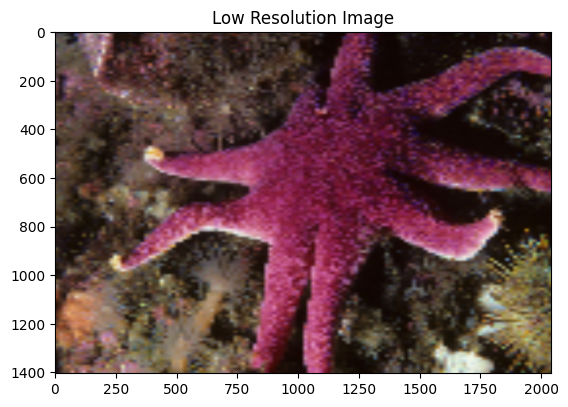

In [7]:
for img_noise  in x_train.take(1):
  break

# 4 dimensiones (batch_size, altura, anchura, canales)
img_noise = img_noise.numpy()
plt.figure()
plt.imshow(img_noise[0])
plt.title('Low Resolution Image')
plt.show()

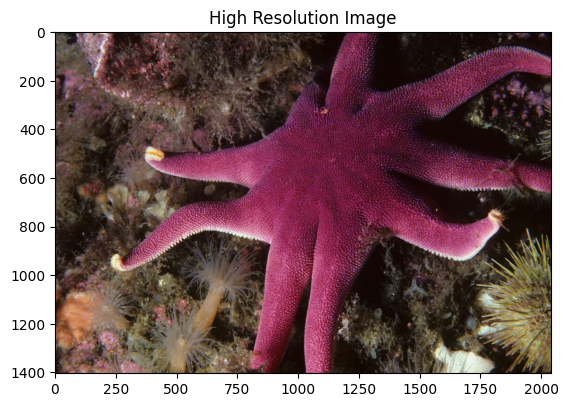

In [6]:
for img in y_train.take(1):
  break

img = img.numpy()
plt.figure()
plt.imshow(img[0])
plt.title('High Resolution Image')
plt.show()

In [ ]:
"""
n = 0
for img_noise,img in train_data:
  if n < 1:
    img_noise = img_noise.numpy()
    img = img.numpy()


    fig, axs = plt.subplots(1 , 2)

    axs[0].imshow(img_noise[0])
    axs[0].set_title('Low Resolution Image')
    axs[1].imshow(img[0])
    axs[1].set_title('High Resolution Image')
    plt.show()

    n+=1

  else:
    break
"""

#Modelo


In [6]:
def get_encoder():
  model = keras.models.Sequential()
  model.add(layers.Conv2D(16,3,activation='relu',input_shape=(1404,2040,3)))
  model.add(layers.AveragePooling2D())
  model.add(layers.Conv2D(32,3,activation='relu'))
  model.add(layers.AveragePooling2D())
  model.add(layers.Conv2D(64,3,activation='relu'))
  model.add(layers.AveragePooling2D())
  model.add(layers.Conv2D(128,3,activation='relu'))
  model.add(layers.AveragePooling2D())
  model.add(layers.Conv2D(256,3,activation='relu'))
  model.add(layers.AveragePooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='sigmoid'))
  return model

In [7]:
def get_decoder():
  model = keras.models.Sequential()
  model.add(layers.Dense(256, activation='relu',input_shape=(256,)))  #REVISAR
  return model

In [8]:
def get_model(encoder,decoder):
  input_layer = layers.Input(shape=(1404,2040,3))
  encoded = encoder(input_layer)
  decoded = decoder(encoded)
  model = keras.Model(inputs=input_layer, outputs=decoded)
  model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])
  return model

In [9]:
encoder = get_encoder()
decoder = get_decoder()
model = get_model(encoder,decoder)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1404, 2040, 3)]   0         
                                                                 
 sequential (Sequential)     (None, 256)               164298400 
                                                                 
 sequential_1 (Sequential)   (None, 256)               65792     
                                                                 
Total params: 164364192 (627.00 MB)
Trainable params: 164364192 (627.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Entrenamiento

In [11]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,verbose=1)
reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,factor=0.2,min_lr=0.00000001)

callbacks = [early_stopping, reduce_lr_on_plateau]

In [ ]:
history = model.fit(train_data, epochs=1000, validation_data=validation_data, verbose=1, callbacks=callbacks)

# Curvas de entrenamiento

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
n = 0
for i,m in validation_data:
    img,mask = i,m
    sr1 = model.predict(img)
    if n < 2:
        fig, axs = plt.subplots(1 , 3)
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(mask[0])
        axs[1].set_title('High Resolution Image')
        axs[2].imshow(sr1[0])
        axs[2].set_title('Predicted High Resolution Image')
        plt.show()
        n+=1
    else:
        break

#Guardar modelo

In [ ]:
path_save = "/content/drive/MyDrive/Deep Learning/Models"

model_path = os.path.join(path_save,'superResolution')
model.save(model_path)